# Part 4: Ranging and Localization <br>
## Srikumar Muralidharan <br>

First record a still image of the scene using raspistill. Then use the ultrasonic distance sensor to record 10 sucessive distance measurements between Pi and the object. Calculate and print average of the 10 measurements. The code for this is attached below:

In [1]:
#Note: the following code is to be executed on RPi
import numpy as np
import RPi.GPIO as gpio
import time
import imutils
import cv2
import os

# Define pin allocation
trig = 16
echo = 18

# Defining the distance calculation function
def distance():
	gpio.setmode(gpio.BOARD)
	gpio.setup(trig,gpio.OUT)
	gpio.setup(echo,gpio.IN)
	
	# Ensure output has no value
	gpio.output(trig, False)
	time.sleep(0.01)

	# Generate trigger pulse
	gpio.output(trig, True)
	time.sleep(0.00001)
	gpio.output(trig, False)

	# Generate echo time signal
	while gpio.input(echo) == 0:
		pulse_start = time.time()
	while gpio.input(echo) == 1:
		pulse_end = time.time()

	pulse_duration = pulse_end - pulse_start

	# Covert time to distance
	distance = pulse_duration*17150
	distance = round(distance, 2)

	# Cleanup gpio pins and return distance estimate
	gpio.cleanup()
	return distance

# Record an image using Raspistill
name = "Assignment4img.jpg"
os.system('raspistill -w 640 -h 480 -o '+ name)

sum=0
count=0
dist = np.zeros(10)
while(count<10):
	dist[count]=distance()
	print("Distance: ", dist[count], " cm")
	sum = sum+dist[count]
	time.sleep(1)
	count=count+1

print("Average of 10 distance measurements: ", round(sum/10,2), " cm")
img = cv2.imread(name)
cv2.putText(img, "Avg Dist: "+str(round(sum/10,2))+" cm",(150,400), cv2.FONT_HERSHEY_SIMPLEX,1,(0,0,255))
cv2.imshow("image",img)
cv2.waitKey(0)
cv2.destroyAllWindows()

I got the following output while measuring the distance between my sensor and my iPad.</br>
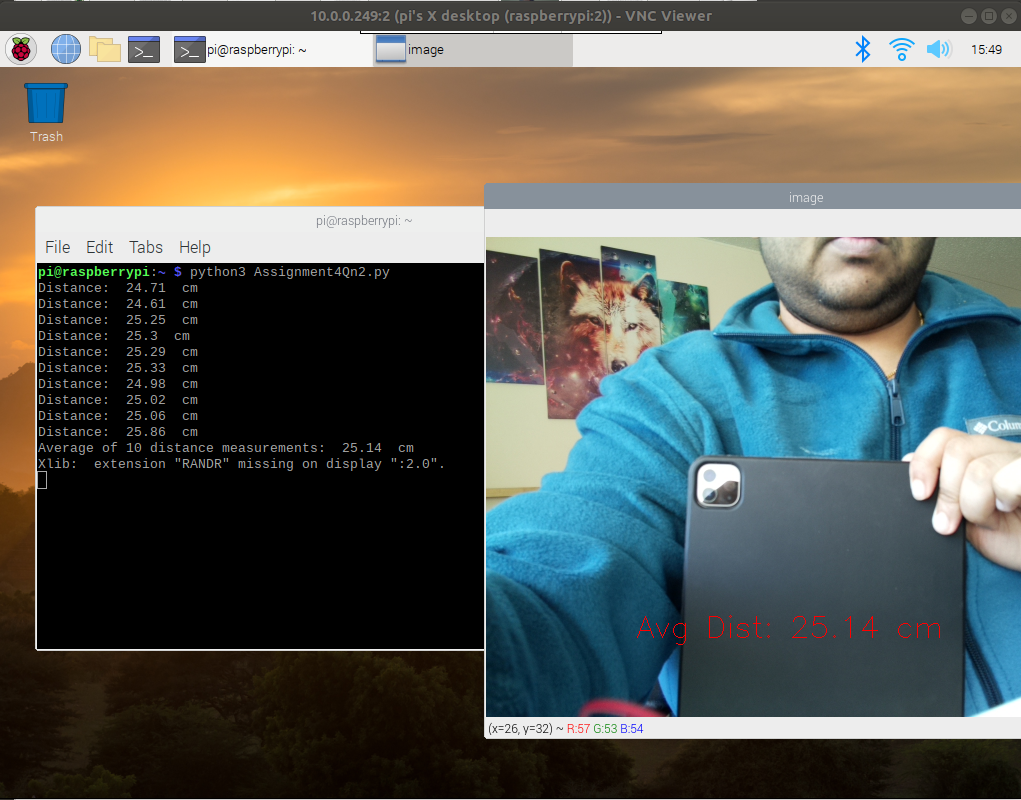

Question 3: Identifying presence and orientation of Green Arrow!<br>

Step 1: Download image of green arrow and display it here.

In [1]:
import cv2
import numpy as np
import imutils
img = cv2.imread("hw4arrow.JPG")
cv2.imshow("arrow",img)
cv2.waitKey(0)
cv2.destroyAllWindows()

This is the downloaded arrow: <br>
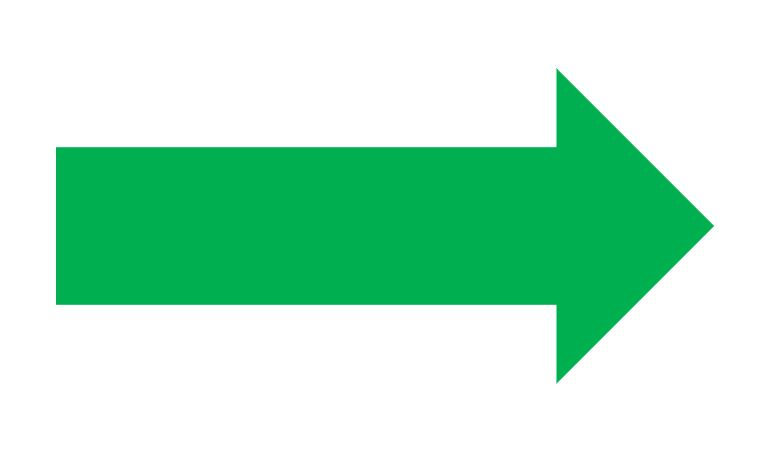

Step 2: Using RPi , record an image of yourself holding the arrow <br>
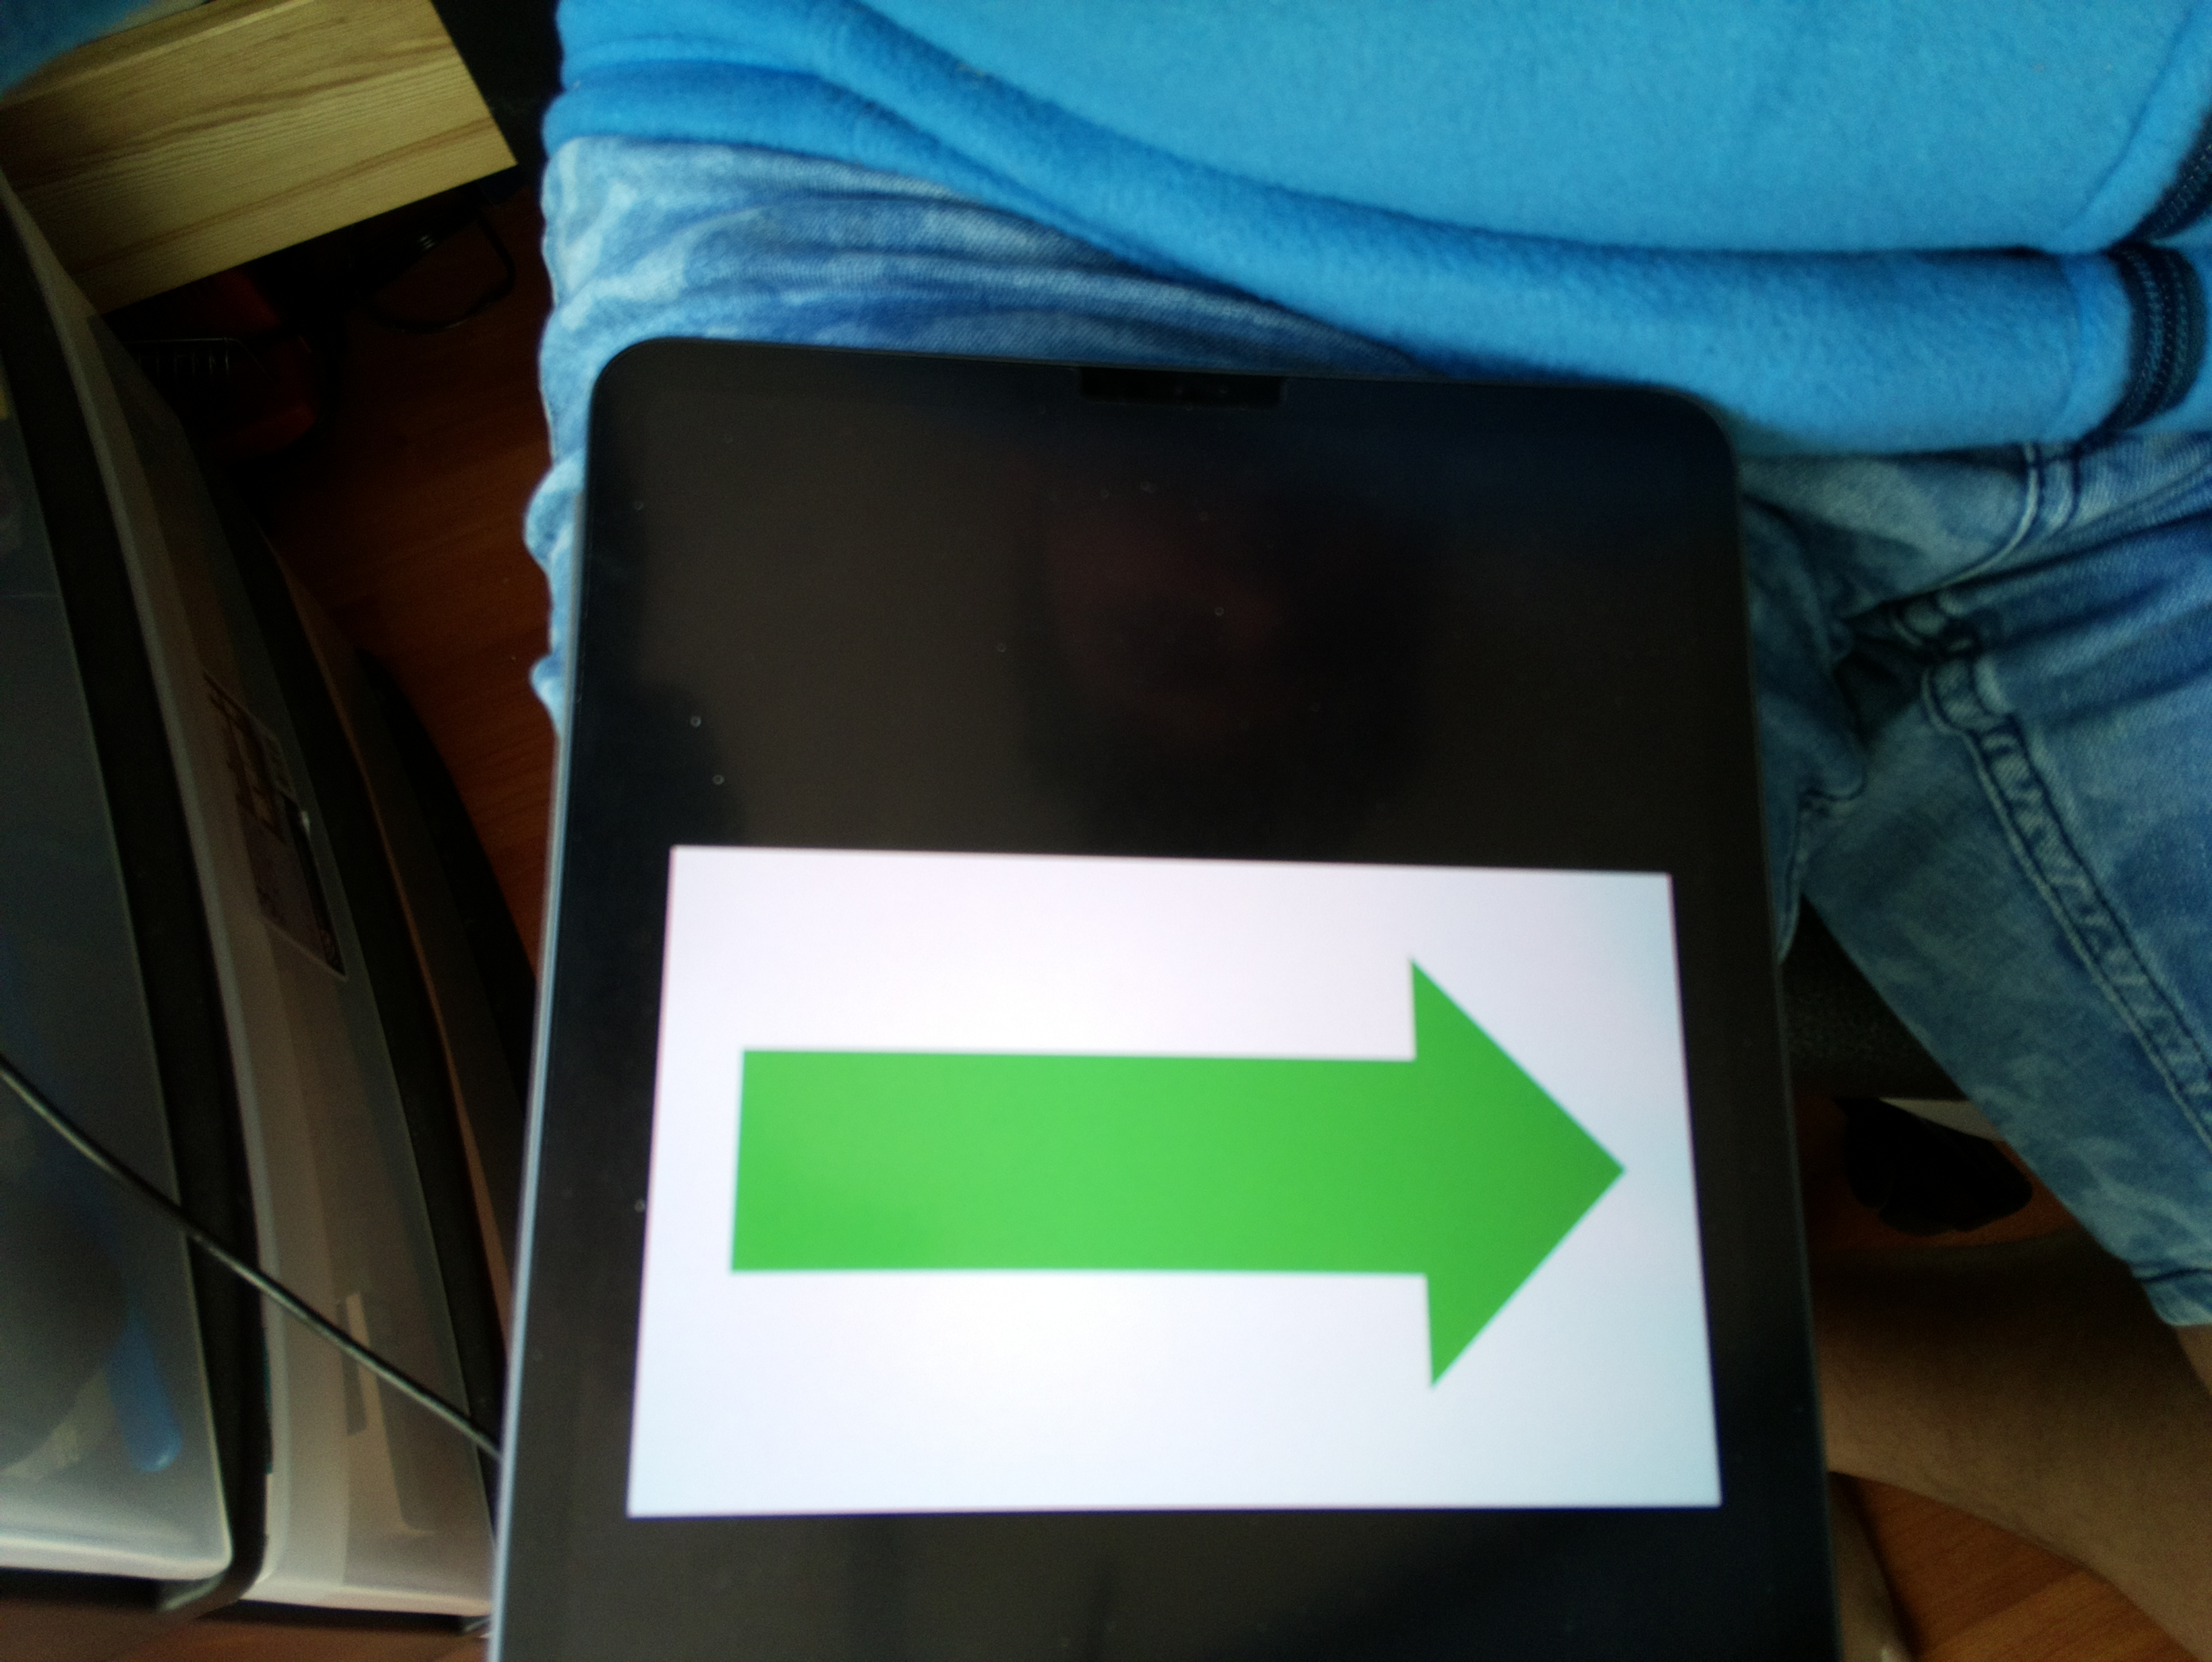

In [2]:
img1 = cv2.imread('menarrow.jpg')
img1 = imutils.resize(img1,width=500)
hsv_img = cv2.cvtColor(img1,cv2.COLOR_BGR2HSV)
Horizontal_stack = np.hstack([img1,hsv_img])
cv2.imshow("Hor", Horizontal_stack)
cv2.waitKey(0)
cv2.destroyAllWindows()

Displaying the horizontal stack <br>
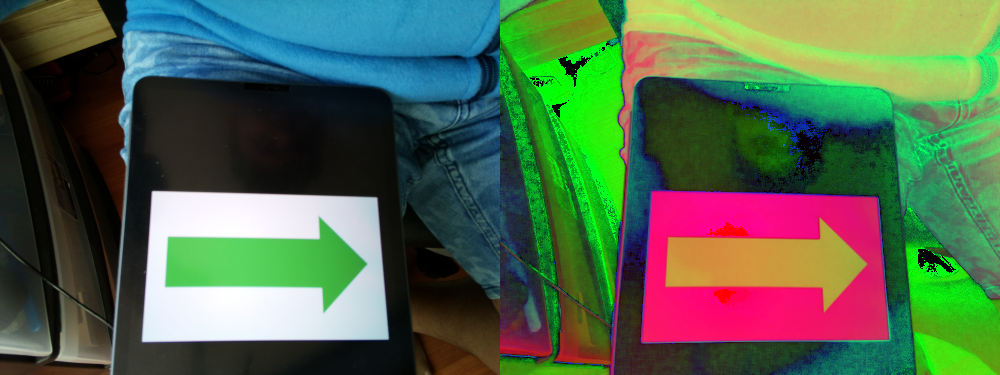

In [3]:
# setting HSV ranges for green after using colorpicker.py used from 
# https://github.com/oneshell/enpm809T/blob/master/colorpicker.py
lower = np.array([50,75,150])
upper = np.array([85,255,255])
hsv_mask = cv2.inRange(hsv_img,lower,upper)
cv2.imshow("mask",hsv_mask)
cv2.waitKey(0)
cv2.destroyAllWindows()

Displaying the mask after segregating based on HSV values: <br>
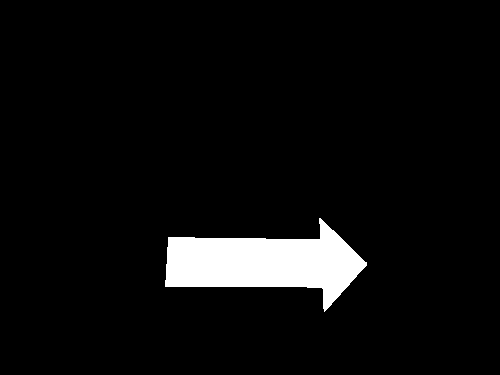

Step 3: Image blurring.

In [1]:
blurred = cv2.GaussianBlur(hsv_mask, (9,9),0)
cv2.imshow('blur',blurred)
cv2.waitKey(0)
cv2.destroyAllWindows()

NameError: name 'cv2' is not defined

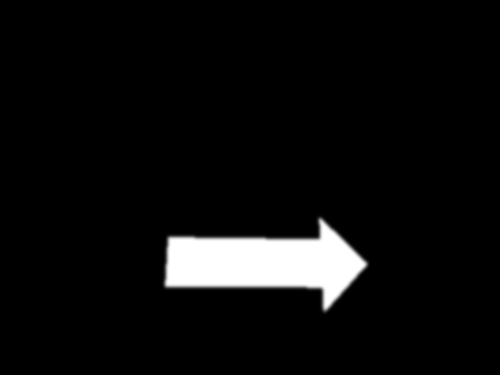 <br>
Step 4: Using Shi Tomasi method to detect corners:

In [5]:
# Needs to dertect 7 sharp corners
x_cord=[]
y_cord=[]
corners = cv2.goodFeaturesToTrack(blurred,7,0.01,10)
corners = np.int0(corners)
for cor in corners:
    x,y = cor.ravel()
    x_cord.append(x)
    y_cord.append(y)
    cv2.circle(img1, (x,y),3,255,-1)
cv2.imshow("corners",img1)
cv2.waitKey(0)
cv2.destroyAllWindows()

Checking for corners:
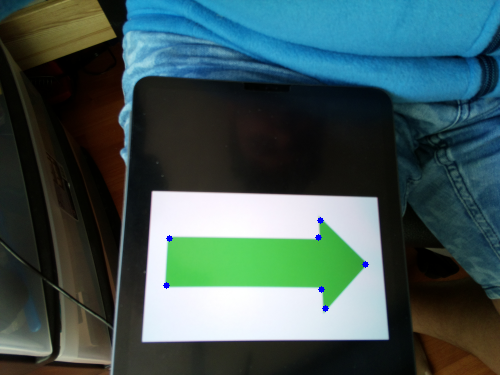

Step 5: Developing a pipeline for orientation detection: <br>
I found an elegant method to detect the direction in which the arrow is pointing. An efficient way is to detect the center point of the arrow, by calculating the spread of x and y coordinates of the arrow in our image. Next, we can detect which spread is larger to detect general orientation (either E_W or N_S). Then, we simple check the x coordinates or y coordinates against our mid coordinates to further refine our original orientation.

In [ ]:
spread_x = max(x_cord)-min(x_cord)
spread_y = max(y_cord)-min(y_cord)
x_center = round((min(x_cord)+max(x_cord))/2)
y_center = round((min(y_cord)+max(y_cord))/2)
if spread_x>spread_y:
    west_pnt=0
    east_pnt=0
    for x in x_cord:
        if x>x_center:
            east_pnt+=1
        else:
            west_pnt+=1
    if east_pnt>west_pnt:
        cv2.putText(img1,'EAST',(10,100),cv2.FONT_HERSHEY_DUPLEX,3,(255,0,255),2)
    else:
        cv2.putText(img1,'WEST',(10,100),cv2.FONT_HERSHEY_DUPLEX,3,(255,0,255),2)
else:
    north_pnt=0
    south_pnt=0
    for y in y_cord:
        if y>y_center:
            south_pnt+=1
        else:
            north_pnt+=1
    if north_pnt>south_pnt:
        cv2.putText(img1,'NORTH',(10,100),cv2.FONT_HERSHEY_DUPLEX,3,(255,0,255),2)
    else:
        cv2.putText(img1,'SOUTH',(10,100),cv2.FONT_HERSHEY_DUPLEX,3,(255,0,255),2)
        
cv2.imshow("final", img1)
cv2.waitKey(0)
cv2.destroyAllWindows()

Detecting the direction here:
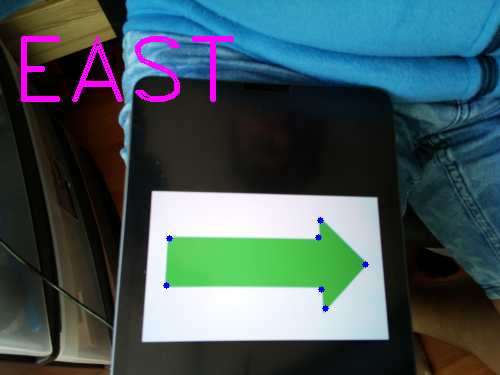

Step 6: Apply to picamera video feed

In [ ]:
# Execute only in RPi

from picamera.array import PiRGBArray
from picamera import PiCamera
import time
import cv2
import numpy as np
import imutils
import datetime

#initialize the Raspberry Pi camera
camera=PiCamera()
camera.resolution=(640,480)
camera.framerate=30
rawCapture=PiRGBArray(camera,size=(640,480))
time.sleep(0.5)
fourcc=cv2.VideoWriter_fourcc(*'XVID')
out=cv2.VideoWriter('Green_arrow.avi',fourcc,10,(640,480))
#allow the camera to warmup
time.sleep(0.1)


file = open('hw4data.txt','a')
i=0

for frame in camera.capture_continuous(rawCapture,format="bgr",use_video_port=False):
    
    start = datetime.datetime.now()
    #grab the currennt frame
    image=frame.array
    
    img1 = cv2.flip(image,-1)
    hsv_img = cv2.cvtColor(img1,cv2.COLOR_BGR2HSV)
    lower = np.array([50,75,150])
    upper = np.array([85,255,255])
    hsv_mask = cv2.inRange(hsv_img,lower,upper)
    blurred = cv2.GaussianBlur(hsv_mask, (9,9),0)
    x_cord=[]
    y_cord=[]
    corners = cv2.goodFeaturesToTrack(blurred,7,0.01,10)
    corners = np.int0(corners)
    for cor in corners:
        x,y = cor.ravel()
        x_cord.append(x)
        y_cord.append(y)
        cv2.circle(img1, (x,y),3,255,-1)
    spread_x = max(x_cord)-min(x_cord)
    spread_y = max(y_cord)-min(y_cord)
    x_center = round((min(x_cord)+max(x_cord))/2)
    y_center = round((min(y_cord)+max(y_cord))/2)
    
    if spread_x>spread_y:
        west_pnt=0
        east_pnt=0
        for x in x_cord:
            if x>x_center:
                east_pnt+=1
            else:
                west_pnt+=1
        if east_pnt>west_pnt:
            cv2.putText(img1,'EAST',(10,100),cv2.FONT_HERSHEY_DUPLEX,3,(255,0,255),2)
        else:
            cv2.putText(img1,'WEST',(10,100),cv2.FONT_HERSHEY_DUPLEX,3,(255,0,255),2)
    else:
        north_pnt=0
        south_pnt=0
        for y in y_cord:
            if y>y_center:
                south_pnt+=1
            else:
                north_pnt+=1
        if north_pnt>south_pnt:
            cv2.putText(img1,'NORTH',(10,100),cv2.FONT_HERSHEY_DUPLEX,3,(255,0,255),2)
        else:
            cv2.putText(img1,'SOUTH',(10,100),cv2.FONT_HERSHEY_DUPLEX,3,(255,0,255),2)
    

    
  	#show the frame to our screen
    cv2.imshow("Final",img1)
    out.write(img1)
    stop = datetime.datetime.now()
    now = (stop-start)
    outstring = str(now.total_seconds())+ '\n'
    print(now.total_seconds())
    file.write(outstring)
    i += 1
    print("i",i)
    
    
    key=cv2.waitKey(1) & 0xFF
    rawCapture.truncate(0)
    if key==ord("q"):
        break
cv2.destroyAllWindows()

Step 7: Youtube upload <br>
Youtube : https://youtu.be/iDpYUZIM0c0 <br>
The youtube link demonstrates how the direction is detected in realtime!

Step 8 contd: Transfer hw4data.txt to laptop. Read the delta-time data and plot it. <br>

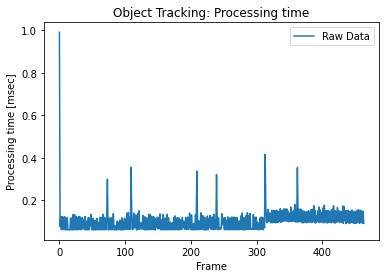

In [1]:
import numpy as np
import matplotlib.pyplot as plt
data = open('hw4data.txt','r').read()
count = 0
delta={}
for row in data.splitlines():
    (key,value)=(count,float(row.split()[0]))
    delta[key]=value  #storing information in this dictionary
    count+=1
# print('delta',delta)
plt.plot(delta.keys(), delta.values(),label='Raw Data')
plt.xlabel('Frame')
plt.ylabel('Processing time [msec]')
plt.title("Object Tracking: Processing time")
plt.legend(loc="upper right")
plt.show()

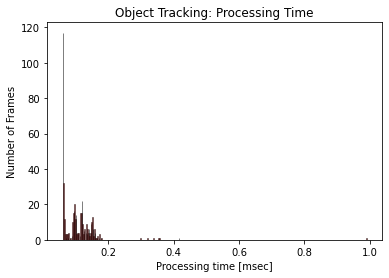

In [2]:
plt.figure(2)
plt.title('Object Tracking: Processing Time')
plt.xlabel('Processing time [msec]')
plt.ylabel('Number of Frames')
n, bins, patches = plt.hist(delta.values(), len(delta.values()), facecolor='r',edgecolor='k', alpha=0.5)
plt.show()

Both these plots display the processing times requried by RPi to iterate through the various frames and we notice spikes inside the loop when we check for direction in each frame. Clearly, we see towards the 300+ mark in plot 1, processing time increase considerably. This means if we run the program for much longer there is a possibility that the Rpi will slow down considerably. So, to get better results in the longer run, we can say the following: <br>

1. Algorithm can be less complex inside loops. <br>
2. Heat sinks need to be employed for the RPi loop. <br>
3. Minimise number of inner iterations. <br>